# Application
This notebook shows the application of the trained neural networks in order to find defects in STEM-HAADF images. Specifically we focus on vacancy defects in bilayer CrSBr, specifically $V_{Br}$, $2V_{Br}^{bi}$, $V_{Cr}$ and $V_{Cr}^{bi}$. We aknowledge that sulfur vacancies are also present in this material, however, due to their low $Z$ contrast and higher formation energy we do not attempt to find these. 

## Investigation of vacancy defects in CrSBr
To shed light on the nature of vacancies and defect complexes in CrSBr we adopt an approach similar to [doi:10.1126/sciadv.aaw8989](https://www.science.org/doi/10.1126/sciadv.aaw8989) in which a defect detecting networking is used in connection with an "atom spotting" network.

In our case we have trained an ensemble of 4 networks to detect defects in bilayer CrSBr. These are available in the [`data/model_weights/`](./data/model_weights/) folder and are named `defect_i` and have associated parameter files names `defect_i_pars.npy`. The training hyperparameters can be extracted from the parameter file, for the exact details view the SI of our paper. 

Similarly, we also have an atom spotting network names `atomspotter` in the same directory. 

In our workflow we subsequently align the different defects to the lattice sites identified by the atomspotting network. Importantly, we only do this alignment for the single defects since the stacked defects can be situated in vacuum where the lattice is not recognized. For each type of defects we extract square cutouts and average these eliminating the influence of false negative predictions that are present under these challenging conditions. For additional detail we refer to our manuscript and its SI.

The workflow can be applied for other multi-layer 2D materials by training networks specifically for these materials. However to create same result with locking to the lattice you would have to adapt the functions to your material of choice.

## Setup
We import the relevant functions to load and use the neural network along with additional helper functions to perform additional analysis of the defects detected by the networks.

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from scipy.spatial import KDTree
from skimage.draw import rectangle
from tqdm import tqdm

# Base imports
import os
import sys
import time
import random

from helpers.preprocessing import load_experimental_data
from helpers.models import create_model
from helpers.processing import model_predict, lock_peaks_to_lattice, col_intensities, rotate_and_cut
from helpers.fitting import find_peaks, show_wave

In [2]:
# load experimental data
images = []
experimental_path = './data/experimental/'
files = [f for f in os.listdir(experimental_path) if '.npy' in f]
files.sort()
for file in files:
    image = np.load(experimental_path+file)
    images.append(image)
images = np.array(images)

print("# Loaded experimental data")

# Loaded experimental data


In [3]:
# load networks
model_path = "./data/model_weights/"
models = [model.split('_pars.')[0] for model in os.listdir(model_path) if ".npy" in model and "defect" in model]
models.sort()
parameter_files = [np.load(model_path+model+"_pars.npy", allow_pickle=True).item() for model in models]
N = len(models)

architecture = parameter_files[0]["architecture"]
defect_finder = create_model(architecture, parameter_files[0]["in_channels"], parameter_files[0]["num_classes"])
defect_finder.eval()

## Load the atomspotter
# load neural network to do line analysis
atomspotter = create_model("unetplusplus", 1, 2)
atomspotter.load_state_dict(torch.load(model_path + "atomspotter", map_location='cpu'))
atomspotter.eval()

print(f"# Loaded networks (defect detectors: {N})")

# Loaded networks (defect detectors: 4)


In [4]:
# Plotting options
label_names = parameter_files[0]['label_names']
defect_names =['V-Br', '2V-Br', 'V-Cr', '2V-Cr']
colors = ["#FFC000","#DB1B79","#00B0F0","#7030A0"]

# load custom color map to produce figures from manuscript
cmap = np.load('./data/cold_colormap.npy', allow_pickle=True).item()
cmap = cmap.reversed()
# vmin vmax args is what we need in figures

plt.rcParams.update({
    'font.size': 10,
    'font.family': 'DejaVu Sans',
    'lines.linewidth': 2,
    'figure.figsize': (30 / 2.54, 6 / 2.54)  # Convert cm to inches
})

## Training summary
This provides a quick summary of the training of the ensemble. In this case the networks have been trained with XXXX parameters

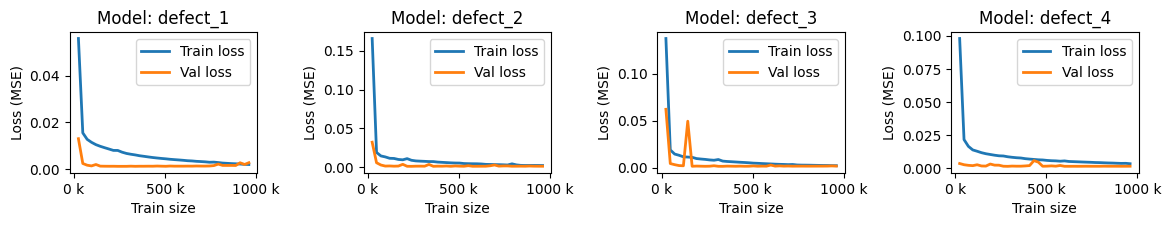

In [5]:
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(1,N)
axs = axs.flatten()
for i in range(N):
    axs[i].plot(parameter_files[i]['train_loss'][:,0]/1000, parameter_files[i]['train_loss'][:,1])
    axs[i].plot(parameter_files[i]['val_loss'][:,0]/1000, parameter_files[i]['val_loss'][:,1])
    axs[i].set_xlabel("Train size")
    axs[i].set_ylabel("Loss (MSE)")
    axs[i].set_title(f"Model: {models[i]}")
    axs[i].xaxis.set_major_formatter(FormatStrFormatter('%d k'))
    axs[i].legend(["Train loss", "Val loss"])
plt.tight_layout()

## Predicting defects on a single image using the ensemble
This creates figure 1

100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


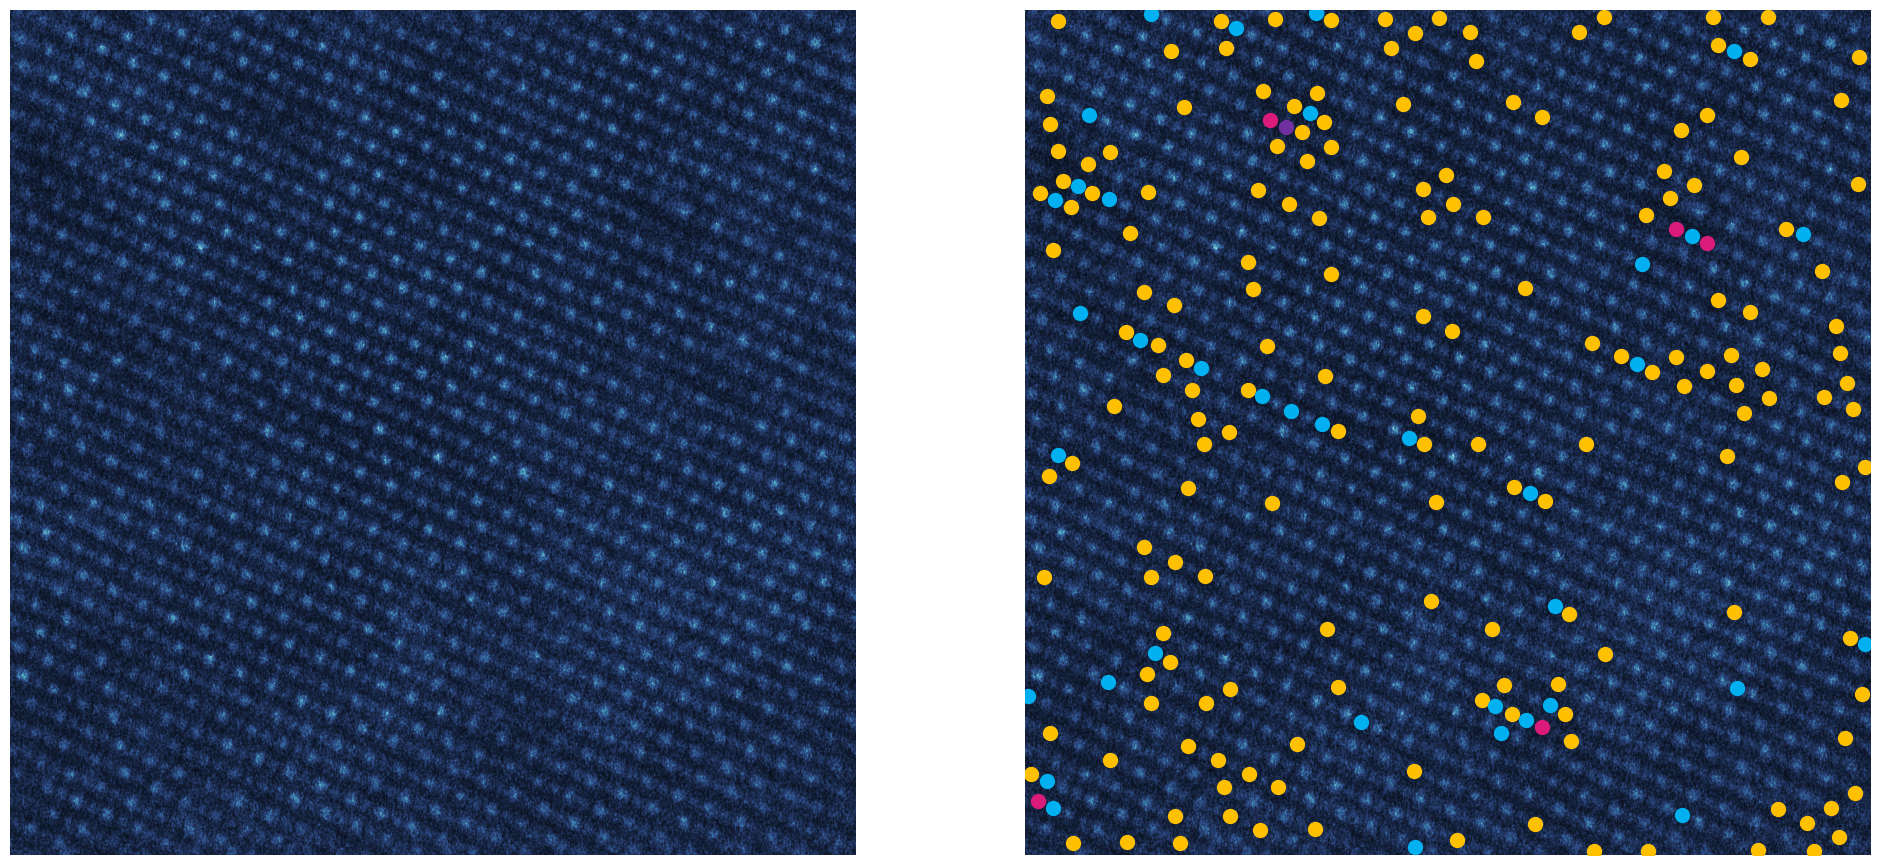

In [6]:
image = images[1] # this is the image shown in Figure 1 of the manuscript

# create upsampled image for alignment purposes
im2 = cv2.resize(image, dsize=np.array(image.shape)*2)

# Plot results of atomspotting
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,12))
show_wave(im2, ax=ax1, cmap=cmap)
ax1.set_axis_off()

## Predict defects at scale x1
predictions = []
for i in tqdm(range(N)):
    defect_finder.load_state_dict(torch.load(model_path+models[i], map_location='cpu'))
    defect_finder.cuda()
    pred = model_predict(image, defect_finder) 
    defect_finder.cpu()
    predictions.append(pred)

# take average ensemble prediction
pred = np.array(predictions).mean(axis=0)

thresholds = [0.95, 0.9, 0.9, 0.9]
# Plot results of defect predictions
for i in range(len(defect_names)):
    ## find color
    channel = (label_names==defect_names[i]).nonzero()[0][0]
    peaks = find_peaks(pred[0,channel,:,:], threshold=thresholds[i], min_dist=4)*2
    ax2.scatter(peaks[:,0], peaks[:,1], c=colors[i], s=100)

show_wave(im2, ax=ax2, cmap=cmap)
ax2.set_axis_off()

## Extracting class-averages

This part of the script locks the defects found to the lattice and extracts the square cutout.

In [7]:
template_size = 200
templates = [[] for d in defect_names]
pred_value = [[] for d in defect_names]
show = False

for i in range(len(images)):
    im = images[i]
    # notice to normalize the different images we divide by the median pixel value
    im2 = cv2.resize(im, dsize=np.array(im.shape)*2) / np.median(im)

    atomspotter.cuda()
    pred = model_predict(im, atomspotter)
    atomspotter.cpu()

    # create map of atomic positions to lock defects to
    position_peaks = find_peaks(pred[0,0,:,:], threshold=0.8, min_dist=4)*2
    point_tree = KDTree(position_peaks, leafsize=100)
    
    if show:
        fig, (ax1, ax) = plt.subplots(1,2,figsize=(24,12))
        show_wave(im2, ax=ax1, cmap=cmap)
        ax1.set_axis_off()
        show_wave(im2, ax=ax, cmap=cmap)
        ax.set_axis_off()
        
    # ensemble prediction
    predictions = []
    for j in tqdm(range(N)):
        defect_finder.load_state_dict(torch.load(model_path+models[j], map_location='cpu'))
        defect_finder.cuda()
        pred = model_predict(im, defect_finder) 
        defect_finder.cpu()
        predictions.append(pred)

    # take average ensemble prediction
    pred = np.array(predictions).mean(axis=0)

    # go through each of the defect names and
    for j in range(len(defect_names)):
        channel = (label_names==defect_names[j]).nonzero()[0][0]
        peaks = find_peaks(pred[0,channel,:,:], threshold=thresholds[j], min_dist=4)*2
        if show:
            ax.scatter(peaks[:,0], peaks[:,1], c=colors[j], s=100)
        
        # extract single vacancies using lattice lock to output from atomspotter
        if j == 0 or j == 2:
            ll, nearest_point = point_tree.query(peaks, 1)
            already_chosen = []
            for k, nn in enumerate(nearest_point):
                if nn not in already_chosen:
                    start = (position_peaks[nn]-template_size)
                    rr, cc = rectangle(start.astype(int), extent=template_size*2, shape=im2.shape)
                    if im2[rr,cc].shape == (template_size*2, template_size*2):
                        templates[j].append(im2[rr,cc])
                        pred_value[j].append(pred[0,channel,peaks[k][0]//2, peaks[k][1]//2])
                    already_chosen.append(nn)
                    
        # Extract double vacancies without lattice lock
        else:
            for k in range(len(peaks)):
                start = peaks[k] - template_size
                rr, cc = rectangle(start.astype(int), extent=template_size*2, shape=im2.shape)
                if im2[rr,cc].shape == (template_size*2, template_size*2):
                    templates[j].append(im2[rr,cc])
                    pred_value[j].append(pred[0,channel,peaks[k][0]//2, peaks[k][1]//2])

100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Class-average of V-Br   created from 1242 instances
Class-average of 2V-Br  created from 64 instances
Class-average of V-Cr   created from 264 instances
Class-average of 2V-Cr  created from 36 instances


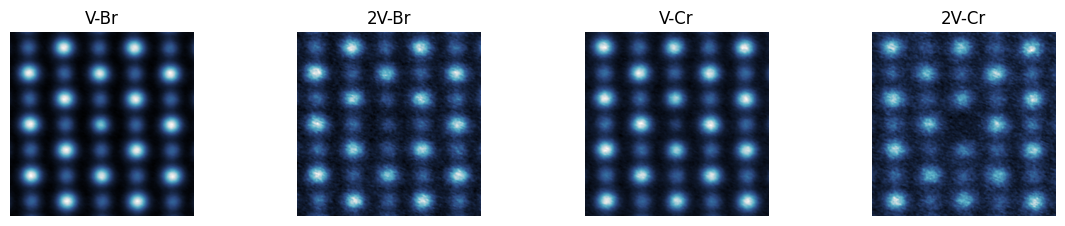

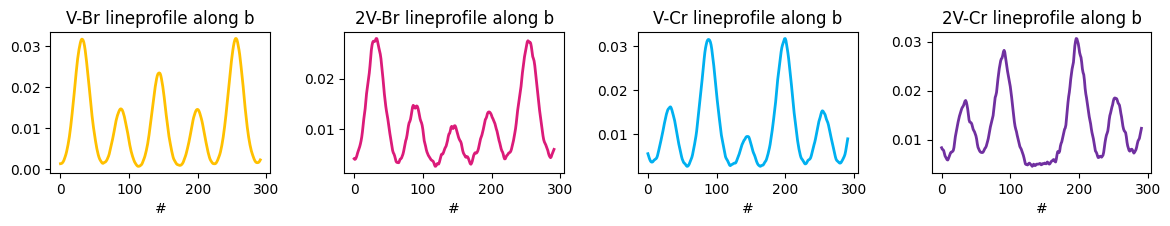

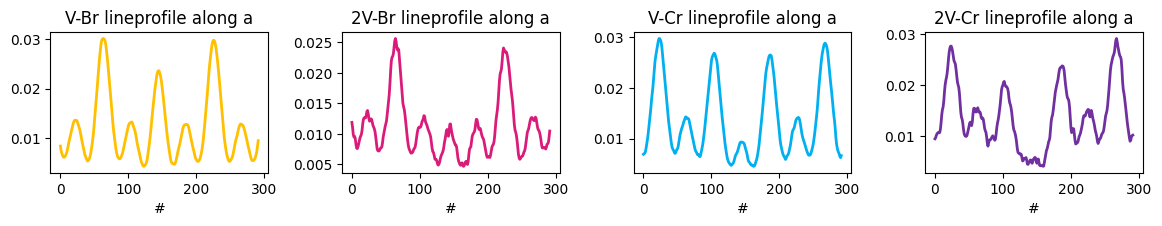

In [8]:
angle = 67

fig, axs1 = plt.subplots(1,len(defect_names))
fig_line_b, axs2 = plt.subplots(1,len(defect_names))
fig_line_a, axs3= plt.subplots(1,len(defect_names))

for i in range(len(defect_names)):
    pred_val = np.array(pred_value[i])
    class_avg = np.mean(np.array(templates[i]), axis=0)
    class_avg = class_avg - class_avg.min()
    rotated = rotate_and_cut(class_avg, angle)
    show_wave(rotated, title=defect_names[i], ax=axs1[i], cmap = cmap)
    axs1[i].set_axis_off()

    # print statistics
    print(f"Class-average of {defect_names[i]:6} created from {len(templates[i])} instances")
    
    # plot line plot along b direction
    # integrate over 26 pixels along the a-direction corresponding to FWHM
    line_profile_b = np.mean(rotated[:, (rotated.shape[0]//2-13):(rotated.shape[0]//2+13)], axis=1)
    axs2[i].plot(line_profile_b, color = colors[i])
    axs2[i].set_title(f"{defect_names[i]} lineprofile along b")
    axs2[i].set_xlabel("#")
    
    # line plot along a-direction
    line_profile_a = np.mean(rotated[(rotated.shape[1]//2-13):(rotated.shape[1]//2+13), :], axis=0)
    axs3[i].plot(line_profile_a, color = colors[i])
    axs3[i].set_title(f"{defect_names[i]} lineprofile along a")
    axs3[i].set_xlabel("#")

fig.tight_layout()
fig_line_b.tight_layout()
fig_line_a.tight_layout()